In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd

## gaussian form excitation

In [32]:
#get omega, sigma, K
def getsigma(m1,m2,alpha,p,s11):        
    beta = alpha + 1/alpha
    sigma = s11 * (1 + p * ((m1**2 * alpha + m2**2/alpha) - beta))
    return sigma

def getomega(m1,m2,alpha,p,D,w11,s11):
    interm = m1**2 * alpha + m2**2/alpha
    beta = alpha + 1/alpha
    omega_sq = D**2 * w11**2 * interm**2 + interm * (s11**2 * (1 - p * beta)**2/beta + w11**2 * (1 - D**2 * beta**2)/beta) - s11**2 * (1 - p * beta)**2
  
    return np.sqrt(omega_sq)
    

def getk(m1,m2,omega,f1,f2):
    k = f1 * f2 * np.sin(m1 * np.pi/2) * np.sin(m2 * np.pi/2)/omega #assuming x1,x2 at center of the surface
    #print(np.sum(k))
    return k



#calculate integral and approximate excitation function with gaussian distribution
def getf(m,l,tau):
    #trapezoid rule to integrate f(x)sin(mpix) from 0 to l
    #(f(a)+f(b))*(b-a)/2
    integral = 0
    x = approxnorm(l,l/2,0.4,tau)
    h = l/tau
    for i in range(tau):
        #x(i+2)
        #print(x.shape,x[0],x[0,1])
        integral = integral + (x[i] * np.sin(m * np.pi * i * h/l) + x[i+1] * np.sin(m * np.pi * (i + 1) * h/l))*h/2
    integral = integral*2/l
    return integral

def get_impf(m,l,tau):
    return np.sin(m/2)*2/l

def approxnorm(l,mu,s,tau):
    h = l/tau
    #x = np.zeros((1,tau + 1))
    x = []
    for i in range(tau+1):
        #x[i] = 1/(s * np.sqrt(2*np.pi)) * np.exp(-0.5 * (i * h - mu)**2/s**2)
        x.append(1/(s * np.sqrt(2*np.pi)) * np.exp(-0.5 * (i * h - mu)**2/s**2))
    return x

def getsounds_imp(m1,m2,w11,tau11,p,D,alpha,sr):
    l = np.pi
    s11 = -1/tau11

    sigma=np.zeros((m1,m2))
    omega=np.zeros((m1,m2))
    k=np.zeros((m1,m2))

    x1 = 1
    x2 = l*alpha/2


    for i in range(m1):
        for j in range(m2):
            sigma[i,j] = getsigma(i+1,j+1,alpha,p,s11)
            omega[i,j] = getomega(i+1,j+1,alpha,p, D,w11,s11)
            k[i,j] = getk(i+1,j+1,omega[i,j],getf(i+1,1,300),getf(j+1,alpha,300)) # the covered striking length is 1
            #k[i,j] = get_del_k(i+1,j+1,omega[i,j],x1,x2,l,alpha)

            #print(get_impf(i+1,1,300),getf(i+1,1,300))
    #sr = 44100
    #print(omega,sigma,k)
    dur = 2**16

    y = []
    for t in range(dur):
        y.append(np.sum(np.sum(k * np.exp(sigma * t/sr) * np.sin(omega * t/sr))))
    return y


In [3]:
w,t,pp,d,a = [3960.1349876368563, 0.09376144165196816, 0.0016713390753826927,
       0.0012821611585344935, 0.23768976773282824]

In [4]:
y_gau = getsounds_imp(10,10,w,t,pp,d,a,44100)
ipd.Audio(y_gau,rate=44100)

NameError: name 'get_del_k' is not defined

In [ ]:
y_gau3 = getsounds_imp(10,10,w,t,pp,d,a,44100)
ipd.Audio(y_gau3,rate=44100)

In [ ]:
y_gau2 = getsounds_imp(10,10,w,t,pp,d,a,44100)
ipd.Audio(y_gau2,rate=44100)

In [ ]:
def approxnorm(l,mu,s,tau):
    h = l/tau
    #x = np.zeros((1,tau + 1))
    x = []
    for i in range(tau+1):
        #x[i] = 1/(s * np.sqrt(2*np.pi)) * np.exp(-0.5 * (i * h - mu)**2/s**2)
        x.append(1/(s * np.sqrt(2*np.pi)) * np.exp(-0.5 * (i * h - mu)**2/s**2))
    return x

In [ ]:
a = approxnorm(1,1/2,0.4,300)

In [ ]:
plt.scatter(range(301),a)

## modified gaussian excitation + position

In [40]:
def get_gaus_k(m1,m2,omega,f1,f2, x1,x2,l,alpha):
    l2 = l * alpha
    if x1 > l:
        x1 = 0
    if x2 > l2:
        x2 = 0
    k = f1 * f2 * np.sin(m1 * np.pi * x1/l) * np.sin(m2 * np.pi * x2/l2)/ omega #assuming x1,x2 at center of the surface
    #print(x1/l,x2/l2)
    k = np.round(k,10)
    return k


#calculate integral and approximate excitation function with gaussian distribution
def get_gaus_f(m,l,tau,r):
    #trapezoid rule to integrate f(x)sin(mpix) from 0 to l
    #(f(a)+f(b))*(b-a)/2
    integral = 0
    x = approxnorm(l,l*r,0.4,tau)
    h = l/tau
    for i in range(tau):
        #x(i+2)
        #print(x.shape,x[0],x[0,1])
        integral = integral + (x[i] * np.sin(m * np.pi * i * h/l) + x[i+1] * np.sin(m * np.pi * (i + 1) * h/l))*h/2
    integral = integral*2/l
    return integral

def getsounds_imp_gaus(m1,m2,r1,r2,w11,tau11,p,D,alpha,sr):
    l = np.pi
    l2 = l*alpha
    s11 = -1/tau11

    sigma=np.zeros((m1,m2))
    omega=np.zeros((m1,m2))
    k=np.zeros((m1,m2))

    x1 = l*r1
    x2 = l2*r2


    for i in range(m1):
        for j in range(m2):
            sigma[i,j] = getsigma(i+1,j+1,alpha,p,s11)
            omega[i,j] = getomega(i+1,j+1,alpha,p, D,w11,s11)
            k[i,j] = get_gaus_k(i+1,j+1,omega[i,j],get_gaus_f(i+1,1,300,r1),get_gaus_f(j+1,alpha,300,r2),x1,x2,l,alpha) # the covered striking length is 1

    #sr = 44100
    #print(omega,sigma,k)
    dur = 2**16

    y = []
    for t in range(dur):
        y.append(np.sum(np.sum(k * np.exp(sigma * t/sr) * np.sin(omega * t/sr))))
    return y,omega


In [41]:
y_gaus = getsounds_imp(10,10,w,t,pp,d,a,44100)

In [42]:
y_gaus_pos = getsounds_imp_gaus(10,10,0.5,0.5,w,t,pp,d,a,44100)
y_gaus_pos2 = getsounds_imp_gaus(10,10,0.1,0.9,w,t,pp,d,a,44100)
y_gaus_pos3 = getsounds_imp_gaus(10,10,0.3,0.1,w,t,pp,d,a,44100)
y_gaus_pos4 = getsounds_imp_gaus(10,10,0.01,0.1,w,t,pp,d,a,44100)

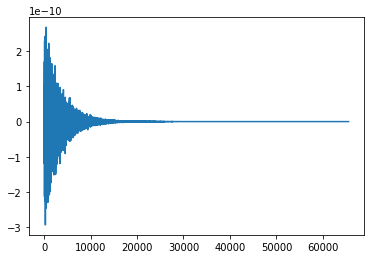

In [43]:
plt.plot(np.array(y_gaus)-np.array(y_gaus_pos[0]))

In [44]:
sum(np.array(y_gaus)-np.array(y_gaus_pos[0]))

5.98063670452574e-11

In [25]:
y_gaus_pos6 =  getsounds_imp_gaus(10,10,0.7,0.1,w,t,pp,d,a,44100)

In [7]:
y_gaus_pos5 = getsounds_imp_gaus(10,10,0.6,0.4,w,t,pp,d,a,44100)

In [17]:
ipd.Audio(y_gaus_pos[0],rate=44100)

In [23]:
ipd.Audio(y_gaus_pos2[0],rate=44100)

In [19]:
ipd.Audio(y_gaus_pos3[0],rate=44100)

In [24]:
ipd.Audio(y_gaus_pos4[0],rate=44100)

In [22]:
ipd.Audio(y_gaus_pos5[0],rate=44100)

In [104]:
y, omega = getsounds_imp_gaus(10,10,0.6,0.4,w*1.2,t,pp,d,a,44100)

In [105]:
print(omega)

[[ 4752.16198516  9312.22779657 13915.27133987 18530.35457567
  23151.4703116  27776.88529017 32406.09691789 37039.06548331
  41675.95711987 46317.04071401]
 [ 5119.18945994  9504.80467872 14044.9142276  18627.94779768
  23229.70040267 27842.16604162 32462.11432849 37088.13101736
  41719.61504019 46356.37356405]
 [ 5678.43405175  9817.37940018 14258.36940967 18789.47898353
  23359.50349165 27950.62997912 32555.26377224 37169.76410648
  41792.27789604 46421.85515916]
 [ 6379.5538276  10238.97413322 14551.95347689 19013.32192185
  23540.02912427 28101.77932606 32685.2297087  37283.75251814
  41893.79626649 46513.37641555]
 [ 7181.12513392 10756.78610023 14920.94323958 19297.31290704
  23770.1253755  28294.93313753 32851.57786701 37429.80300314
  42023.96312725 46630.78590013]
 [ 8053.22253835 11357.67284819 15359.91263779 19638.848535
  24048.37411316 28529.24223761 33053.76238082 37607.54503174
  42182.51595354 46773.89108475]
 [ 8975.32668434 12029.20297124 15863.06193965 20034.9930474

In [106]:
t_approx = np.pi/2/omega[0,0]
t_true = np.argmax(y)/44100
print(t_approx,t_true)

0.0003305435150777194 0.0016553287981859411


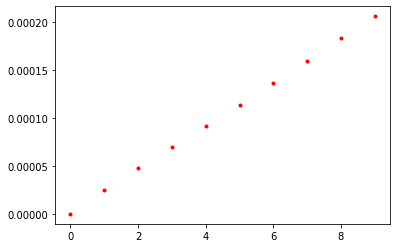

In [68]:
plt.plot(y_gaus_pos[:10], 'r.')

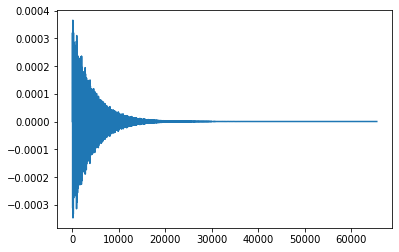

In [54]:
plt.plot(y_gaus_pos5)

## delta function excitation

In [13]:
def get_del_k(m1,m2,omega,x1,x2,l,alpha):
    l2 = l * alpha
    if x1 > l:
        x1 = 0
    if x2 > l2:
        x2 = 0
    k = 4/(l * l2) * (np.sin(m1 * np.pi * x1/l))**2 * (np.sin(m2 * np.pi * x2/l2))**2 / omega #assuming x1,x2 at center of the surface
    k = np.round(k,10)
    return k


def hitdiffparts(r1,r2,w11,tau11, p, D,alpha):
    
    #w11=200 * 2 * np.pi#range 200hz-1200hz
    #tau11 = 0.2#range 0.01-0.3
    s11 = -1/tau11
    p = 0.3 #how round the sound is, smaller the rougher(metal), range 0-0.3
    D = 0.01 #inharmonicity in smaller values, range 0-10
    alpha = 1 #range 0-5

    m1 = 10
    m2 = 10
    l = np.pi
    l2 = l * alpha
    
    x1 = l*r1
    x2 = l2*r2
    
    sigma=np.zeros((m1,m2))
    omega=np.zeros((m1,m2))
    k=np.zeros((m1,m2))

    for i in range(m1):
        for j in range(m2):
            sigma[i,j] = getsigma(i+1,j+1,alpha,p,s11)
            omega[i,j] = getomega(i+1,j+1,alpha,p, D,w11,s11)
            #k[i,j] = getk(i+1,j+1,omega[i,j],getf(i+1,1,300),getf(j+1,alpha,300))
            k[i,j] = get_del_k(i+1,j+1,omega[i,j],x1,x2,l,alpha)
    
    sr = 44100
    dur = 2**15


    y = []
    for t in range(dur):
        y.append(np.sum(np.sum(k * np.exp(sigma * t/sr) * np.sin(omega * t/sr))))

    y2 = y/np.max(np.abs(np.array(y)))
    

    #ipd.Audio(y2,rate=sr)
    return y2


In [56]:
y_del = hitdiffparts(0.5,0.5,w,t, pp, d,a)
ipd.Audio(y_del,rate=44100)

In [57]:
y_del = hitdiffparts(0.1,0.9,w,t, pp, d,a)
ipd.Audio(y_del,rate=44100)